# ***Tarea 7. Random Forest***
### Luis Eduardo Jiménez del Muro - 20/03/2025
---

# *Paqueterías y funciones*

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Gráfica de calibracion
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False) + 1
    grouped = df_calibracion.groupby('bins').mean()
    r2 = r2_score(y_pred=predicciones, y_true=y)
    
    # Gráfica
    plt.figure(figsize=(7,5))
    plt.plot(grouped['predicciones'], grouped['predicciones'], label='Real', color='red', lw=1.5)
    plt.plot(grouped['predicciones'], grouped['y'], label='Modelo', marker='o', color='cadetblue', ms=4, lw=2)
    plt.title(f'Calibración del modelo \n\n$R2={r2:.4f}$', fontweight='bold')
    plt.grid(alpha=0.3)
    plt.legend()

    
# Regresión Polinómica grado n
def polynomial(X, y, type, n, q):
    scaler = StandardScaler().fit(X)
    X_scaled = scaler.transform(X)

    poly_features = PolynomialFeatures(degree=n)
    X_poly = poly_features.fit_transform(X_scaled)
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

    model = type.fit(X_train, y_train)
    predicciones_poly_2 = model.predict(X_test)
    calibracion(predicciones_poly_2, y_test, q)


# Random Forest
def random_forest(X, y, q):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    pipeline = Pipeline([
    ('rf', RandomForestRegressor(n_estimators=100, n_jobs=-1))
    ])
    params = {
        'rf__max_depth': [1, 2, 5, 8, 10, 15, 30, 50, 100],
        'rf__max_features': ['log2', 'sqrt', len(X.columns)*0.7, len(X.columns)]
    }

    rf_grid = GridSearchCV(estimator=pipeline, n_jobs=-1, cv=5, scoring='r2', param_grid=params)
    rf_grid.fit(X_train, y_train)
    predicciones_rf = rf_grid.predict(X_test)
    calibracion(predicciones_rf, y_test, q)

# *Preparar los datos*

In [3]:
df = pd.read_csv('data/Boston.csv')
df = df.drop(columns=['Unnamed: 0'])
df = pd.get_dummies(df, columns=['rad'])
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,tax,ptratio,...,medv,rad_1,rad_2,rad_3,rad_4,rad_5,rad_6,rad_7,rad_8,rad_24
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,296,15.3,...,24.0,True,False,False,False,False,False,False,False,False
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,242,17.8,...,21.6,False,True,False,False,False,False,False,False,False
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,242,17.8,...,34.7,False,True,False,False,False,False,False,False,False
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,222,18.7,...,33.4,False,False,True,False,False,False,False,False,False
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,222,18.7,...,36.2,False,False,True,False,False,False,False,False,False


# *Mejor modelo realizado en el examen*

## Variables creadas en feature engeneering

In [4]:
# Variables modificadas
modified_features_df = pd.DataFrame()
modified_features_df['rm_2'] = df['rm']**2
modified_features_df['tax_2'] = df['tax']**2
modified_features_df['nox_2'] = df['nox']**2
modified_features_df['ptratio_2'] = df['ptratio']**2
modified_features_df['indus_2'] = df['indus']**2
modified_features_df['crim_2'] = df['crim']**2
modified_features_df['age_2'] = df['age']**2
modified_features_df['lstat_2'] = df['lstat']**2
modified_features_df['ln_dist'] = np.log(1+df['dis']) # +1 para evitar ln(0)

# Nuevas variables
new_features_df = pd.DataFrame()
new_features_df['crim_indus'] = df['crim'] / (1+df['indus']) # +1 para evitar divisiones entre cero
new_features_df['crim_lstat'] = df['crim'] / (1+df['lstat'])
new_features_df['rm_lstat'] = df['rm'] / (1+df['lstat'])
new_features_df['nox_indus'] = df['nox'] / (1+df['indus'])
new_features_df['nox_dis'] = df['nox'] / (1+df['dis'])
new_features_df['age_lstat'] = df['age'] / (1+df['lstat'])
new_features_df['tax_rm'] = df['tax'] / (1+df['rm'])
new_features_df['tax_lstat'] = df['tax'] / (1+df['lstat'])
new_features_df['ptratio_rm'] = df['ptratio'] / (1+df['rm'])
new_features_df['ptratio_nox'] = df['ptratio'] / (1+df['nox'])
new_features_df['ptratio_dis'] = df['ptratio'] / (1+df['dis'])
new_features_df['nox_age'] = df['nox'] / (1+df['age'])
new_features_df['dis_indus'] = df['dis'] / (1+df['indus'])
new_features_df['tax_indus'] = df['tax'] / (1+df['indus'])

# Nuevos dataframes para futuras pruebas
df_mod_plus_originals = pd.concat([df, modified_features_df], axis=1)
df_new_feat_plus_originals = pd.concat([df, new_features_df], axis=1)
df_all_new_plus_originals = pd.concat([df, modified_features_df, new_features_df], axis=1)
df_all_new_not_originals = pd.concat([df[['medv']], modified_features_df, new_features_df], axis=1)

## Modelo

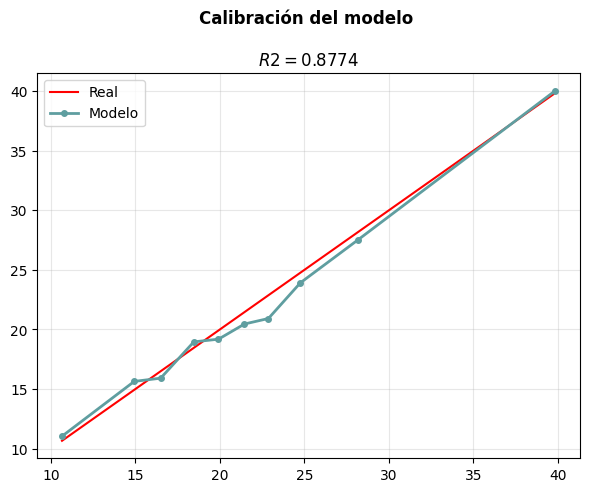

In [5]:
target = 'medv'
X = df_all_new_not_originals.copy().drop(columns={target})
y = df[target]

polynomial(X, y, Ridge(), 2, 10)

# *Modelos de Random Forest*

## Modelo utilizando las variables originales + dummies 

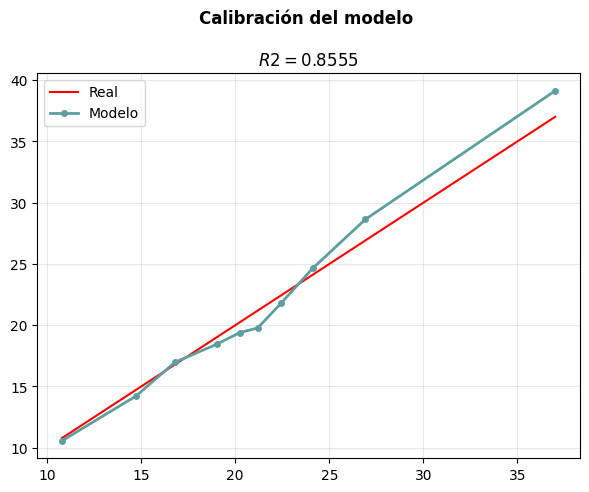

In [6]:
X = df.copy().drop(target, axis=1)
y = df[target]

random_forest(X, y, 10)

## Modelo utilizando las variables del mejor resultado en el examen

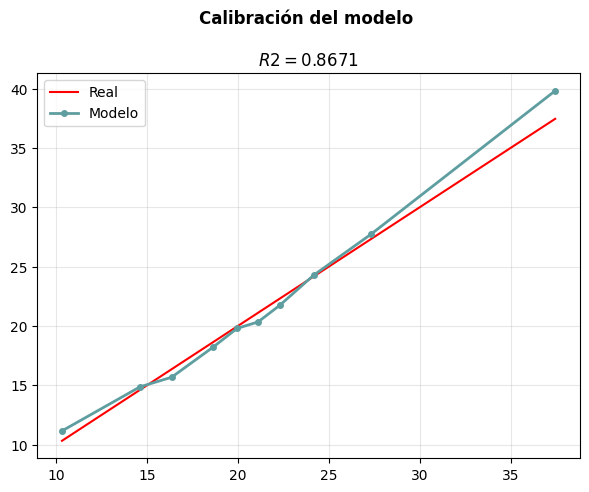

In [7]:
X = df_all_new_not_originals.copy().drop(columns={target})
y = df[target]

random_forest(X, y, 10)

# *Conclusiones*

La implementación de los Random Forest tuvo un buen resultado, ya que, el modelo que realicé en el examen despues de un largo análisis de los datos y feature engeneering obtuvo un $\text{R}^2 = 0.8774$, mientras que un el Random Forest con los datos originales y sin haber creado ninguna nueva variable obtuvo un $\text{R}^2 = 0.8555.$

Esto significa que aunque en el examen se obtuvo un ajuste un poco mejor, el random forest tuvo casi el mismo desempeño y ni siquiera tuvo que realizarse un análisis a los datos, por lo que, estos modelos pueden ser convenientes para entregar un modelo robusto y de buenos resultados en muy poco tiempo.

Además el Random Forest utilizando las variables que obtuvieron el mejor $\text{R}^2$ en el examen tuvo prácticamente el mismo resultado a la regresión realizada en el examen, por lo que, se puede observar que una vez realizando un análisis a los datos y feature engeneering, al menos en este dataset, no es necesario crear modelos como el Random Forest para obtener resultados mejores.

Cabe recalcar que al manos en este set de datos los resultados que se obtuvieron con las redes neuronales fueron un poco mejores que los Random Forest, sin embargo, aquellos modelos fueron mas tardados de entrenar. En cambio, los Random Forest fueron un poco mas rápido y tienen la ventaja de la interpretabilidad.